In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import json 

## Import game data

In [2]:
with open('../data/game-tracking/game-001_765-820.json') as f: 
    content = json.load(f)
    
# Vars

trackersNames = content['ref_objects']
trackersReg = content['ref_objects_location']

itemsNames = content['ref_players']
itemsReg = content['ref_players_location']

limitX = content['limits'][0]
limitY = content['limits'][1]

In [3]:
triangles =  [
    ["L22","L32","L33"],
    ["L11","L12","L21"],
    ["L12","L13","L23"],
    ["L13","L14","L25"],
    ["L21","L12","L22"],
    ["L12","L22","L23"],
    ["L23","L13","L24"],
    ["L13","L24","L25"],
    ["L21","L22","L32"],
    ["L22","L23","L33"],
    ["L23","L33","L34"],
    ["L23","L24","L34"],
    ["L24","L34","L35"],
    ["L24","L25","L35"],
    ["L25","L36","L54"],
    ["L21","L31","L51"],
    ["L21","L31","L32"],
    ["L31","L32","L41"],
    ["L35","L25","L36"],
    ["L31","L42","L41"],
    ["L32","L41","L33"],
    ["L33","L34","L53"],
    ["L34","L42","L35"],
    ["L35","L36","L42"],
    ["L36","L42","L54"],
    ["L42","L53","L54"],
    ["L34","L42","L53"],
    ["L33","L52","L53"],
    ["L33","L41","L52"],
    ["L31","L41","L51"],
    ["L51","L52","C1"],
    ["C1","L52","C2"],
    ["L52","C2","L53"],
    ["L53","C3","L54"]
]

In [4]:
plotTrackersCoors = {
    'C1': [ 337.48 , 3.77 ],
    'C2': [ 337.48 , 144.58 ],
    'C3': [336.69 , 283.54 ],
    'L11': [ 4.46  , 38.68 ],
    'L12': [4.12  , 99.92 ],
    'L13': [ 3.85 , 191.6  ],
    'L14': [ 4.64 , 250.44 ],
    'L21': [ 40.89 , 6.92 ],
    'L22': [ 40.63 , 109.11  ],
    'L23': [ 29.6 , 144.58 ],
    'L24': [ 40.89 , 180.3 ],
    'L25': [ 40.63 , 282.49 ],
    'L31': [ 112.61 , 23.21 ],
    'L32': [ 107.09 , 71.28 ],
    'L33': [ 101.84 , 119.36 ],
    'L34': [ 102.1 , 169.01 ],
    'L35': [ 107.09 , 217.34 ],
    'L36': [ 112.09 , 264.89 ],
    'L41': [  155.69, 69.45 ],
    'L42': [ 155.43 , 220.23 ],
    'L51': [ 253.15 , 4.82 ],
    'L52': [ 270.49 , 71.28 ],
    'L53': [ 270.49 , 218.39 ],
    'L54': [ 253.15 , 283.54 ]
}

In [5]:
itemsNames

['PUCK',
 'P_LOC_1',
 'P_LOC_2',
 'P_LOC_3',
 'P_LOC_4',
 'P_LOC_5',
 'P_VIS_1',
 'P_VIS_2',
 'P_VIS_3',
 'P_VIS_4',
 'P_VIS_5',
 'P_VIS_6']

In [6]:
def getPlayerNum( _itemName ):
    targetItem = None
    
    for itemReg in itemsReg:
        if itemReg['name'] == _itemName:
            targetItem = itemReg
            break
    
    if targetItem:
        return targetItem['num']

    

def getItemCoorByFrame( _itemName, _frameIdx ):
    
    targetReg = None
    
    # Select in wich list-frames-registry to have coordinates: trackers or players/puck
    if _itemName in itemsNames:
        targetReg = itemsReg
    elif _itemName in trackersNames:
        targetReg = trackersReg
    else:
        return None
    
    # Find by frame entry
    targetItem = None
    
    for itemReg in targetReg:
        if itemReg['name'] == _itemName:
            targetItem = itemReg
            break
    
    if not targetItem:
        print('not found it')
        return None
        
    for coor in targetItem['coors']:
        if coor[2] == _frameIdx:
            return coor
            


## Calculate

In [7]:
class Vector:
    def __init__(self, x, y):
        self.x = x
        self.y = y

In [8]:
def isPointInTriangle(p, p0, p1, p2):
    dX = p.x-p2.x;
    dY = p.y-p2.y;
    dX21 = p2.x-p1.x;
    dY12 = p1.y-p2.y;
    D = dY12*(p0.x-p2.x) + dX21*(p0.y-p2.y);
    s = dY12*dX + dX21*dY;
    t = (p2.y-p0.y)*dX + (p0.x-p2.x)*dY;
    if D<0:
        return s<=0 and t<=0 and s+t>=D;
    return s>=0 and t>=0 and s+t<=D;

In [9]:
def barycentric_coords(vertices, point):
    T = (np.array(vertices[:-1])-vertices[-1]).T
    v = np.dot(la.inv(T), np.array(point)-vertices[-1])
    v.resize(len(vertices))
    v[-1] = 1-v.sum()
    return v

In [10]:
# Delta correction in x,y screen-capture-coordinates to plot-coordinates

d = 172.34

def mapX(_x):
    return round(_x  * d, 3)

def mapY(_y):
    return round(474 - (_y * d), 3)

In [11]:
txs = [plotTrackersCoors[key][0]  for key in plotTrackersCoors]
tys = [plotTrackersCoors[key][1]  for key in plotTrackersCoors]

### Map coors

In [12]:
def draw( pName, frameTarget, _pxs, _pys, _labels= [] ):
    
    
    a = None
    b = None
    c = None
    
    p = None
    
    pNum = getPlayerNum(pName)
    
    isV = False
    
    for triangleVertices in triangles:
        cAName = triangleVertices[0] #'L11'
        cBName = triangleVertices[1] #'L23'
        cCName = triangleVertices[2] #'L34'

        # Scene triangle and item coordinates

        a = getItemCoorByFrame( cAName, frameTarget)
        b = getItemCoorByFrame( cBName, frameTarget)
        c = getItemCoorByFrame( cCName, frameTarget)

        p = getItemCoorByFrame(pName, frameTarget)

        # check is in triangle
        va = Vector( a[0], a[1])
        vb = Vector( b[0], b[1])
        vc = Vector( c[0], c[1])

        vp = Vector( p[0], p[1])

        isV = isPointInTriangle(vp, va, vb, vc)
        # 

        if isV:  
            print(pName,' (', pNum, ') ', ' >> is in triangle: ', triangleVertices )
            break

    if not isV:
        print(pName,' (', pNum, ') ', ' >> NOT in any triangle' )
        return

    aX= mapX(a[0])
    aY= mapY(a[1])

    bX= mapX(b[0])
    bY= mapY(b[1])

    cX= mapX(c[0])
    cY= mapY(c[1])

    pX = mapX(p[0])
    pY = mapY(p[1])

    bCoords = barycentric_coords([ [aX, aY],[bX, bY],[cX, cY]], [pX,pY])

    # Plot triangle and item coordinates

    [aX_, aY_ ] = plotTrackersCoors[cAName]
    [bX_, bY_ ] = plotTrackersCoors[cBName]
    [cX_, cY_ ] = plotTrackersCoors[cCName]

    pX_ = round((bCoords[0]*aX_ + bCoords[1]*bX_ + bCoords[2]*cX_), 3)
    pY_ = round((bCoords[0]*aY_ + bCoords[1]*bY_ + bCoords[2]*cY_), 3)
    
    _pxs.append(pX_)
    _pys.append(pY_)
    _labels.append(pNum)
    
    

--- 

In [64]:
frameTarget = 800

---

In [65]:
itemPlotCoors = {}

for itemName in itemsNames:
    # itemName -> 'P_LOC_2'
    [x, y, frame] = getItemCoorByFrame( itemName, frameTarget)

    pX = mapX(x)
    pY = mapY(y)
    
    itemPlotCoors[itemName]= [pX, pY]

itemPlotCoors

{'PUCK': [258.51, 274.086],
 'P_LOC_1': [317.106, 263.745],
 'P_LOC_2': [525.637, 241.341],
 'P_LOC_3': [875.487, 284.426],
 'P_LOC_4': [872.04, 229.277],
 'P_LOC_5': [884.104, 460.213],
 'P_VIS_1': [284.361, 262.022],
 'P_VIS_2': [454.978, 284.426],
 'P_VIS_3': [551.488, 398.17],
 'P_VIS_4': [551.488, 251.681],
 'P_VIS_5': [691.083, 253.405],
 'P_VIS_6': [613.53, 251.681]}

In [66]:
# Home players dots

hxs = []
hys = []
hls = []

home = [
    'P_LOC_1',
    'P_LOC_2',
    'P_LOC_3',
    'P_LOC_4',
    'P_LOC_5', 
]

for pName in home: # pName = 'P_VIS_1'
    draw( pName, frameTarget, hxs,hys,hls )

P_LOC_1  ( 24 )   >> is in triangle:  ['L23', 'L33', 'L34']
P_LOC_2  ( 22 )   >> is in triangle:  ['L21', 'L22', 'L32']
P_LOC_3  ( 17 )   >> is in triangle:  ['L33', 'L41', 'L52']
P_LOC_4  ( 44 )   >> is in triangle:  ['L21', 'L31', 'L51']
P_LOC_5  ( 16 )   >> is in triangle:  ['L33', 'L52', 'L53']


In [67]:
# Visitor players dots

vxs = []
vys = []
vls = []

visitors = [
    'P_VIS_1',
    'P_VIS_2',
    'P_VIS_3',
    'P_VIS_4',
    'P_VIS_5',
    'P_VIS_6'
]

for pName in visitors: # pName = 'P_VIS_1'
    draw( pName, frameTarget, vxs, vys, vls )

P_VIS_1  ( 41 )   >> is in triangle:  ['L23', 'L33', 'L34']
P_VIS_2  ( 75 )   >> is in triangle:  ['L33', 'L34', 'L53']
P_VIS_3  ( 44 )   >> is in triangle:  ['L34', 'L42', 'L53']
P_VIS_4  ( 10 )   >> is in triangle:  ['L22', 'L32', 'L33']
P_VIS_5  ( 15 )   >> is in triangle:  ['L31', 'L32', 'L41']
P_VIS_6  ( 2 )   >> is in triangle:  ['L32', 'L41', 'L33']


In [68]:
# Puck dot

pxs = []
pys = []

draw( 'PUCK', frameTarget, pxs, pys)

PUCK  (  )   >> is in triangle:  ['L23', 'L33', 'L34']


## Plot trackers

In [69]:
homeColor = '#880000'
visitorColor = 'grey'

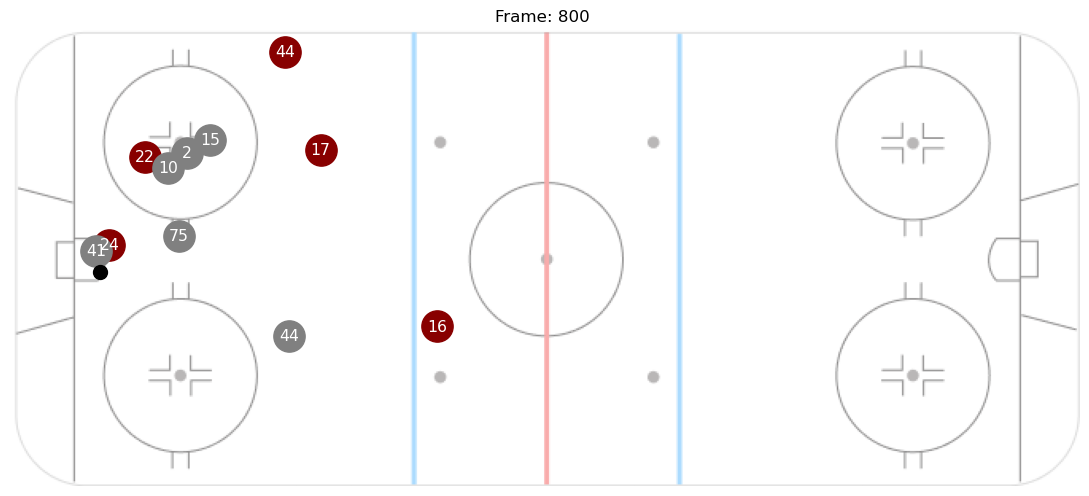

In [70]:
dpi = 100

fw = 11
fh = 5.5

dotSize = 45
annotationSize = dotSize/4
puckSize= 20

minimal= True

figSize = (fw,fh)
fig, ax = plt.subplots()

plt.rcParams["figure.figsize"] = figSize
plt.rcParams["figure.autolayout"] = True
fig.set_dpi(dpi)

if not minimal:
    major_ticks = np.arange(0, 1900, 10)
    minor_ticks = np.arange(0, 800, 10)

    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)

    plt.xticks(fontsize=7,rotation = 45)
    plt.yticks(fontsize=7)

    ax.grid(which='both', alpha=0.2)
else:
    plt.axis('off')



img = plt.imread("./assets/rink-bg-plot_simple.png")

ax.set_title(f'Frame: {frameTarget} ',fontsize=12)

# ax.plot(txs, tys, '.', linewidth=2, color='black', markersize=12)

ax.plot(hxs, hys, '.', linewidth=2, color=homeColor, markersize=dotSize)
ax.plot(vxs, vys, '.', linewidth=2, color=visitorColor, markersize=dotSize)
ax.plot(pxs, pys, '.', linewidth=2, color='black', markersize=puckSize)

for i, txt in enumerate(hls):
    ax.annotate(txt, (hxs[i], hys[i]), ha='center', va="center", color='white', size=annotationSize)
    
for i, txt in enumerate(vls):
    ax.annotate(txt, (vxs[i], vys[i]), ha='center', va="center", color='white', size=annotationSize)

ax.imshow(img)

plt.savefig(f'./output/002.2_{frameTarget}.png', dpi=dpi)